In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from data_utils import *
from datasets import *
from sklearn.metrics import mean_squared_error

############################# Place the games here ############################
train_game_names = ['Barbie', 'Kawaii_Fire_Station', 'Kawaii_Playroom', 'Kawaii_Police_Station']
test_game_names = ['Kawaii_House', 'Kawaii_Daycare']
val_game_names = ['Kawaii_House', 'Kawaii_Daycare']

In [2]:
######################### Place files for splits ##################################
######################### Must be similar to csv of predicted values ##################################
train_sessions = DataUtils.read_txt("/data/mala711/COMPSCI715/datasets/final_data_splits/train.txt")
val_sessions = DataUtils.read_txt("/data/mala711/COMPSCI715/datasets/final_data_splits/val.txt")
test_sessions = DataUtils.read_txt("/data/mala711/COMPSCI715/datasets/final_data_splits/test.txt")

col_pred = ["thumbstick_left_x", "thumbstick_left_y", "thumbstick_right_x", "thumbstick_right_y", "head_pos_x", "head_pos_y", "head_pos_z", "head_dir_a", "head_dir_b", "head_dir_c", "head_dir_d"]

train_set = MultiGameDataset(train_game_names, train_sessions, cols_to_predict=col_pred)
val_set = MultiGameDataset(val_game_names, val_sessions, cols_to_predict=col_pred)
test_set = MultiGameDataset(test_game_names, test_sessions, cols_to_predict=col_pred) 

# Normalisation
thumbsticks_loc = 6
head_pos_loc = 9

test_set.df

,game_session,frame,thumbstick_left_x,thumbstick_left_y,thumbstick_right_x,thumbstick_right_y,head_pos_x,head_pos_y,head_pos_z,head_dir_a,head_dir_b,head_dir_c,head_dir_d
0,383_1_Kawaii_House,5,0.0,0.0,0.0,0.0,0.040368,0.000779,-0.292320,-0.152528,-0.072006,0.034280,0.985076
1,383_1_Kawaii_House,10,0.0,0.0,0.0,0.0,0.042613,0.000985,-0.293077,-0.152321,-0.081466,0.032831,0.984421
2,383_1_Kawaii_House,15,0.0,0.0,0.0,0.0,0.044897,0.000666,-0.294188,-0.153821,-0.091814,0.030927,0.983338
3,383_1_Kawaii_House,20,0.0,0.0,0.0,0.0,0.046807,0.000248,-0.296162,-0.156448,-0.098936,0.028615,0.982302
4,383_1_Kawaii_House,25,0.0,0.0,0.0,0.0,0.048089,-0.000325,-0.298689,-0.158817,-0.103082,0.026143,0.981564
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87819,127_2_Kawaii_Daycare,38660,0.0,0.0,0.0,0.0,0.027261,-0.038352,0.020102,-0.060912,-0.027487,0.012812,0.997682
87820,127_2_Kawaii_Daycare,38670,0.0,0.0,0.0,0.0,0.025195,-0.039456,0.021405,-0.065118,-0.019947,0.013867,0.997582
87821,127_2_Kawaii_Daycare,38680,0.0,0.0,0.0,0.0,0.022528,-0.045457,0.018244,-0.092502,-0.014968,0.015138,0.995485
87822,127_2_Kawaii_Daycare,38690,0.0,0.0,0.0,0.0,0.027305,-0.059022,0.010884,-0.150970,-0.036648,0.009306,0.987815


In [3]:
train_set.df[train_set.df.columns[2:thumbsticks_loc]] = (train_set.df[train_set.df.columns[2:thumbsticks_loc]] + 1) / 2
val_set.df[val_set.df.columns[2:thumbsticks_loc]] = (val_set.df[val_set.df.columns[2:thumbsticks_loc]] + 1) / 2
test_set.df[test_set.df.columns[2:thumbsticks_loc]] = (test_set.df[test_set.df.columns[2:thumbsticks_loc]] + 1) / 2

train_set.df[train_set.df.columns[thumbsticks_loc:head_pos_loc]] = (train_set.df[train_set.df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4
val_set.df[val_set.df.columns[thumbsticks_loc:head_pos_loc]] = (val_set.df[val_set.df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4
test_set.df[test_set.df.columns[thumbsticks_loc:head_pos_loc]] = (test_set.df[test_set.df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4

train_set.df[train_set.df.columns[head_pos_loc:]] = (train_set.df[train_set.df.columns[head_pos_loc:]] + 1) / 2
val_set.df[val_set.df.columns[head_pos_loc:]] = (val_set.df[val_set.df.columns[head_pos_loc:]] + 1) / 2
test_set.df[test_set.df.columns[head_pos_loc:]] = (test_set.df[test_set.df.columns[head_pos_loc:]] + 1) / 2

In [4]:
########################## File of csv predictions ##################################

pred_df = pd.read_csv("/data/mala711/COMPSCI715/CNNRNN/csv_files/GRU_CPCA_train_['Barbie', 'Kawaii_Fire_Station', 'Kawaii_Playroom', 'Kawaii_Police_Station']_test_['Kawaii_House', 'Kawaii_Daycare']_init_test_seq_size_50_seqstart_20_iter_10_reg_1e-05_lr_0.01_dropout_0.2_weighting_True.csv")
gail_df = pd.read_csv("/data/mala711/COMPSCI715/GAIL/csv_files/GAILv2_GRU_train_['Barbie', 'Kawaii_Fire_Station', 'Kawaii_Playroom', 'Kawaii_Police_Station']_test_['Kawaii_House', 'Kawaii_Daycare']_ppoepochs_10_mini_batch_10_lr_0.03_dlr_0.003_init_test_seq_size_50_iter_10_dropout_0.4_weightd_0.005.csv")
vtra_df = pd.read_csv("/data/mala711/COMPSCI715/ViT/csvs/vivit_preds.csv")
resn_df = pd.read_csv("/data/mala711/COMPSCI715/transfer-learning/csv_files/resnet50_prediction_20241004.csv")
resL_df = pd.read_csv("/data/mala711/COMPSCI715/transfer-learning/csv_files/ResNet-LSTM-normalized_data.csv")
gimg_df = pd.read_csv("/data/mala711/COMPSCI715/GAIL/csv_files/GAILimg_train_['Barbie', 'Kawaii_Fire_Station', 'Kawaii_Playroom', 'Kawaii_Police_Station']_test_['Kawaii_House', 'Kawaii_Daycare']_ppoepochs_10_mini_batch_10_lr_0.03_dlr_0.003_init_test_seq_size_50_iter_10_dropout_0.4_weightd_0.005.csv")
gtra_df = pd.read_csv("/data/mala711/COMPSCI715/GAIL/csv_files/GAIL_transfer_['Barbie', 'Kawaii_Fire_Station', 'Kawaii_Playroom', 'Kawaii_Police_Station']_test_['Kawaii_House', 'Kawaii_Daycare']_ppoepochs_10_mini_batch_10_lr_0.03_dlr_0.003_init_test_seq_size_50_iter_10_dropout_0.4_weightd_0.005.csv")

In [5]:
def unnormalise(df, save_name = None):
    df[df.columns[2:thumbsticks_loc]] = 2*df[df.columns[2:thumbsticks_loc]] - 1
    df[df.columns[thumbsticks_loc:head_pos_loc]] = 4*df[df.columns[thumbsticks_loc:head_pos_loc]] - 2
    df[df.columns[head_pos_loc:]] = 2*df[df.columns[head_pos_loc:]] - 1

    if save_name:
        save_temp = df.loc[:, ['frame',"head_dir_a", "head_dir_b", "head_dir_c", "head_dir_d"]]
        save_temp.to_csv(f'/data/mala711/COMPSCI715/rotation_csvs/{save_name}.csv', index = False) 

    return df

# unnormalise(gtra_df, 'rotation_gail_resnet')

In [6]:
resn_df[resn_df.columns[2:thumbsticks_loc]] = (resn_df[resn_df.columns[2:thumbsticks_loc]] + 1) / 2
resn_df[resn_df.columns[thumbsticks_loc:head_pos_loc]] = (resn_df[resn_df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4
resn_df[resn_df.columns[head_pos_loc:]] = (resn_df[resn_df.columns[head_pos_loc:]] + 1) / 2

# resL_df[resL_df.columns[2:thumbsticks_loc]] = (resL_df[resL_df.columns[2:thumbsticks_loc]] + 1) / 2
# resL_df[resL_df.columns[thumbsticks_loc:head_pos_loc]] = (resL_df[resL_df.columns[thumbsticks_loc:head_pos_loc]] + 2) / 4
# resL_df[resL_df.columns[head_pos_loc:]] = (resL_df[resL_df.columns[head_pos_loc:]] + 1) / 2

In [7]:
true_df = test_set.df

# Create ids for to filter rows
pred_df['full_name'] = pred_df['game_session'] + pred_df['frame'].astype(str)
gail_df['full_name'] = gail_df['game_session'] + gail_df['frame'].astype(str)
vtra_df['full_name'] = vtra_df['game_session'] + vtra_df['frame'].astype(str)
resn_df['full_name'] = resn_df['game_session'] + resn_df['frame'].astype(str)
resL_df['full_name'] = resL_df['game_session'] + resL_df['frame'].astype(str)
true_df['full_name'] = true_df['game_session'] + true_df['frame'].astype(str)
gimg_df['full_name'] = gimg_df['game_session'] + gimg_df['frame'].astype(str)
gtra_df['full_name'] = gtra_df['game_session'] + gtra_df['frame'].astype(str)

mask = true_df['full_name'].isin(pred_df['full_name'])
filtered_df = true_df[mask]

mask = vtra_df['full_name'].isin(pred_df['full_name'])
vitransf_df = vtra_df[mask]

mask = resn_df['full_name'].isin(pred_df['full_name'])
resnetfi_df = resn_df[mask]

mask = resL_df['full_name'].isin(pred_df['full_name'])
resnetLS_df = resL_df[mask]

fin_true_df = filtered_df.sort_values(by = ['game_session', 'frame'])
fin_true_df = fin_true_df.reset_index(drop='index')

fin_pred_df = pred_df.sort_values(by = ['game_session', 'frame'])
fin_pred_df = fin_pred_df.reset_index(drop='index')

fin_gail_df = gail_df.sort_values(by = ['game_session', 'frame'])
fin_gail_df = fin_gail_df.reset_index(drop='index')

fin_vtra_df = vitransf_df.sort_values(by = ['game_session', 'frame'])
fin_vtra_df = fin_vtra_df.reset_index(drop='index')

fin_resn_df = resnetfi_df.sort_values(by = ['game_session', 'frame'])
fin_resn_df = fin_resn_df.reset_index(drop='index')

fin_resL_df = resnetLS_df.sort_values(by = ['game_session', 'frame'])
fin_resL_df = fin_resL_df.reset_index(drop='index')

fin_gimg_df = gimg_df.sort_values(by = ['game_session', 'frame'])
fin_gimg_df = fin_gimg_df.reset_index(drop='index')

fin_gtra_df = gtra_df.sort_values(by = ['game_session', 'frame'])
fin_gtra_df = fin_gtra_df.reset_index(drop='index')

# Get matrices for prediction
pred_mat = fin_pred_df.iloc[:, 2:-1].to_numpy()
true_mat = fin_true_df.iloc[:, 2:-1].to_numpy()
gail_mat = fin_gail_df.iloc[:, 2:-1].to_numpy()
vtra_mat = fin_vtra_df.iloc[:, 2:-1].to_numpy()
resn_mat = fin_resn_df.iloc[:, 2:-1].to_numpy()
resL_mat = fin_resL_df.iloc[:, 2:-1].to_numpy()

In [8]:
###################### Calculate MSE for control ######################
for i in range(11):
    mse = mean_squared_error(true_mat[:, i], pred_mat[:, i])
    c = i+2
    print(f'{fin_pred_df.columns[c]}: {mse}')

mean_squared_error(true_mat, pred_mat)

thumbstick_left_x: 0.020185859898394356
thumbstick_left_y: 0.13581040992267146
thumbstick_right_x: 0.003464585516024306
thumbstick_right_y: 0.0029046281251290827
head_pos_x: 0.012286956539777807
head_pos_y: 0.000442257758817895
head_pos_z: 0.004900525786956065
head_dir_a: 0.005515067151291351
head_dir_b: 0.05037971978902581
head_dir_c: 0.0008550253319451775
head_dir_d: 0.0045691611663612915


0.021937654271490418

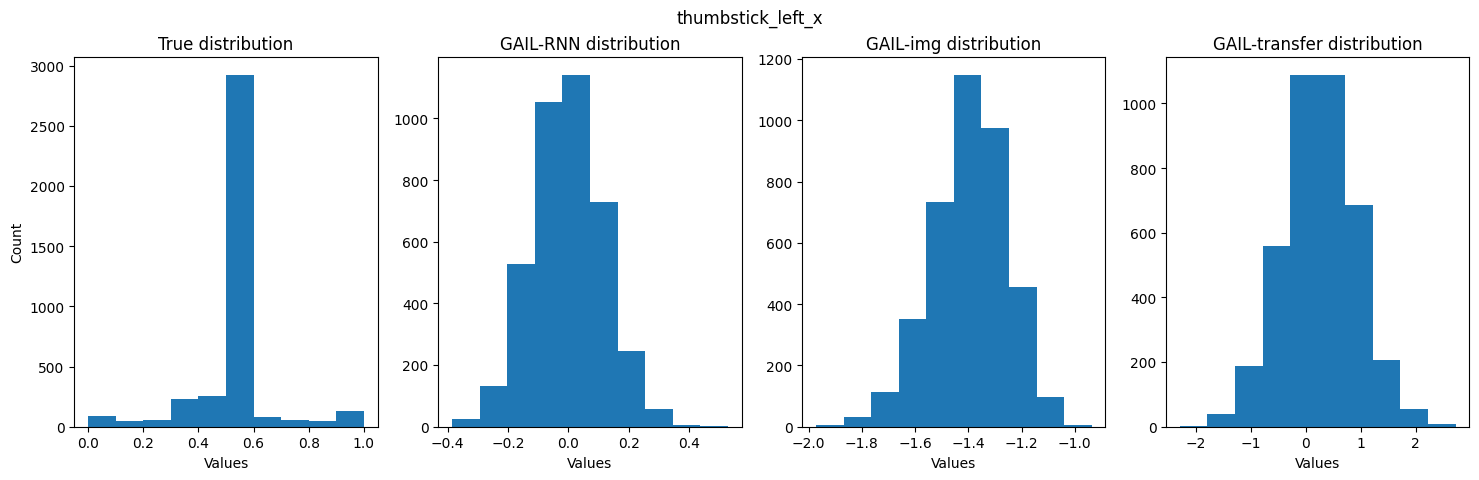

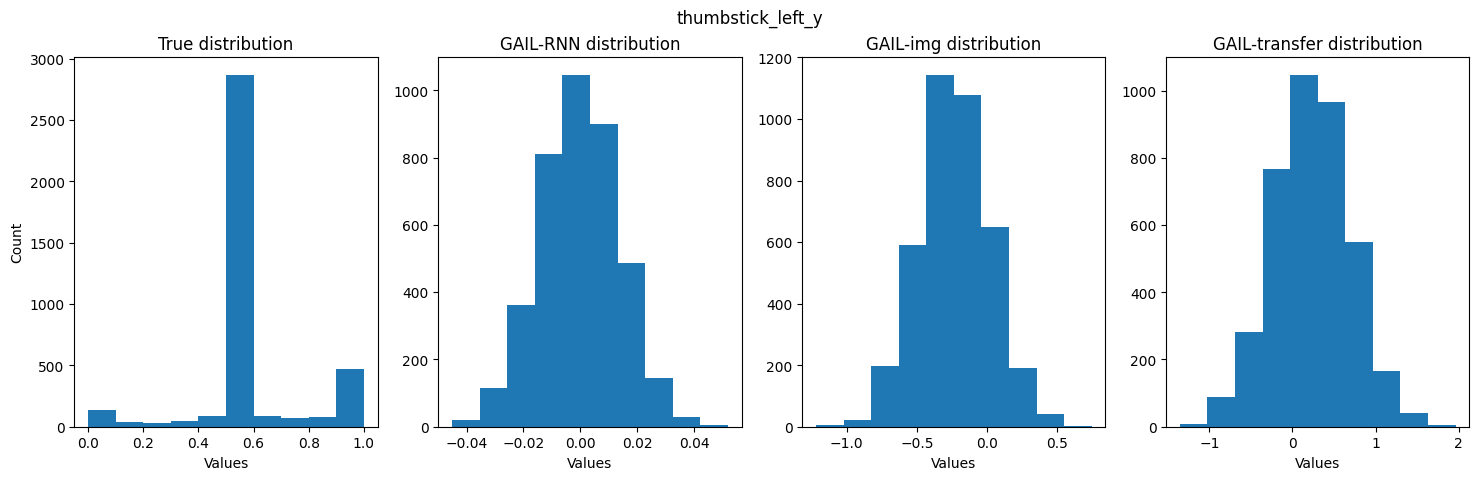

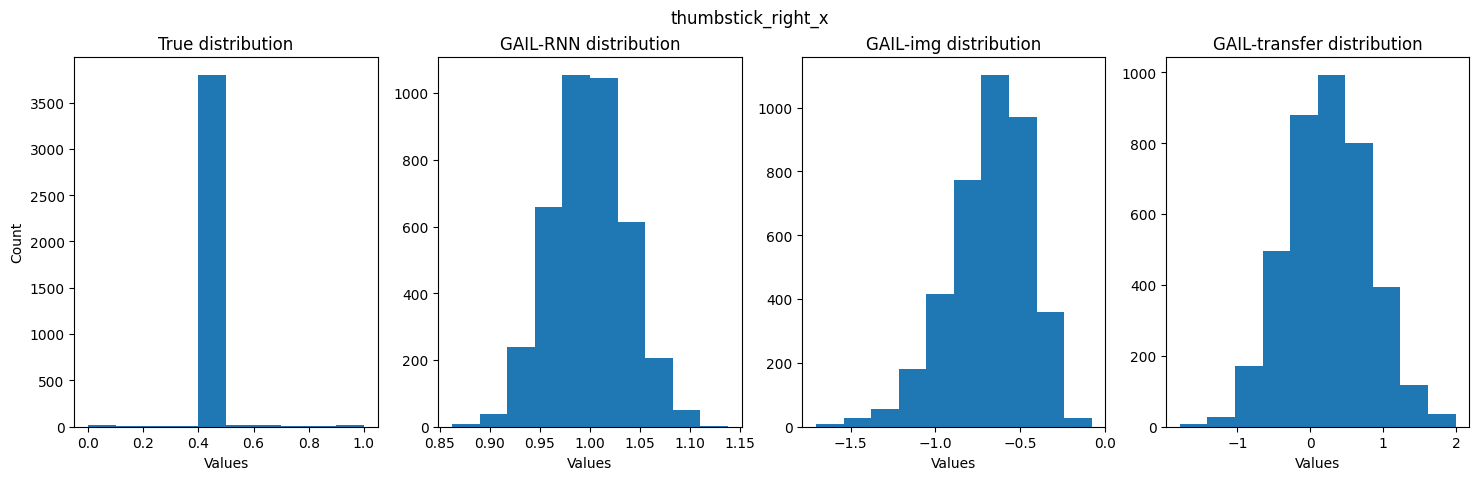

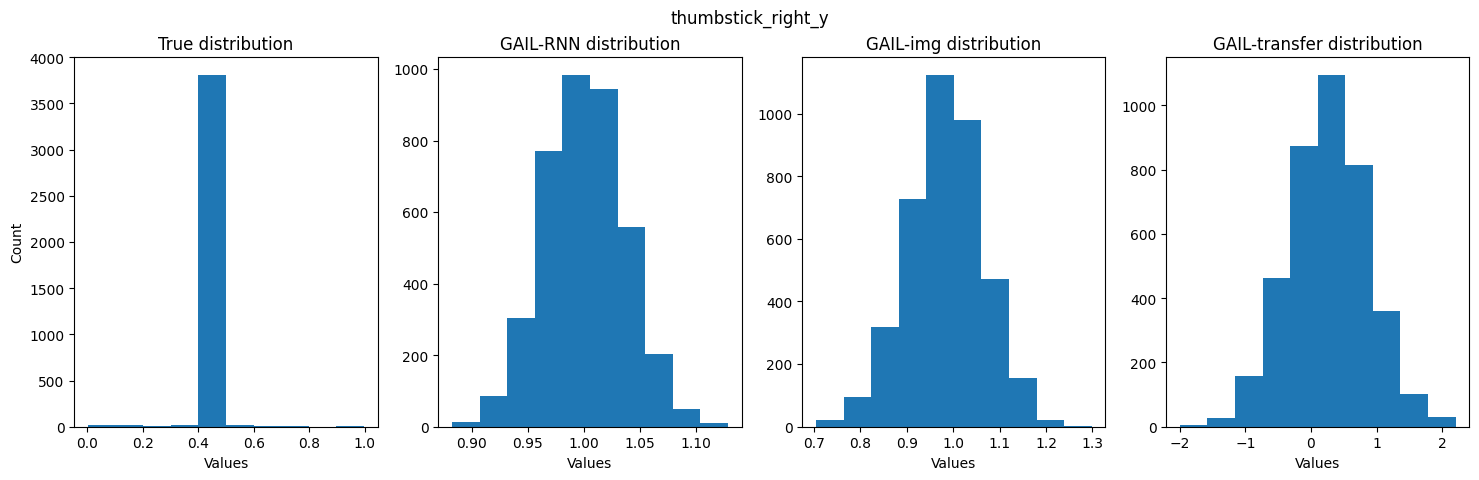

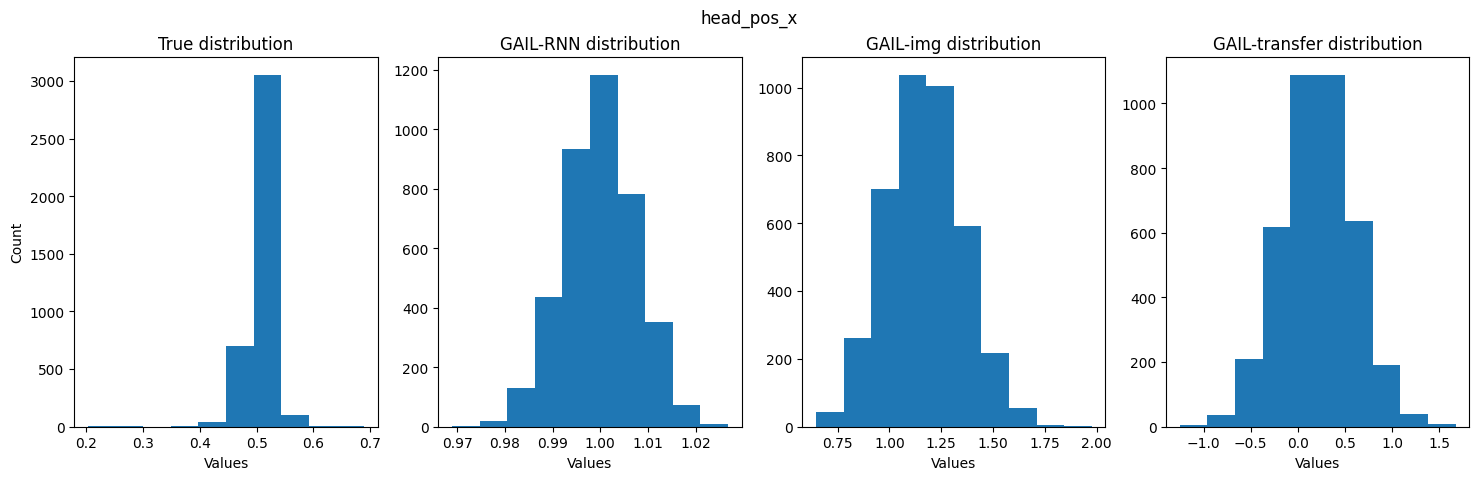

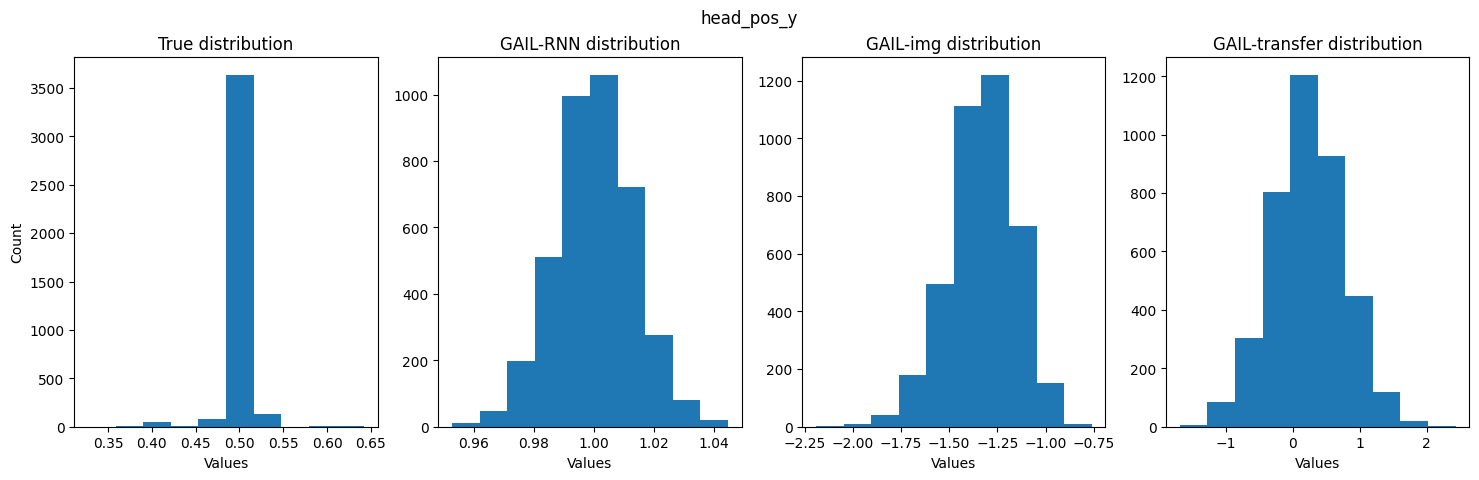

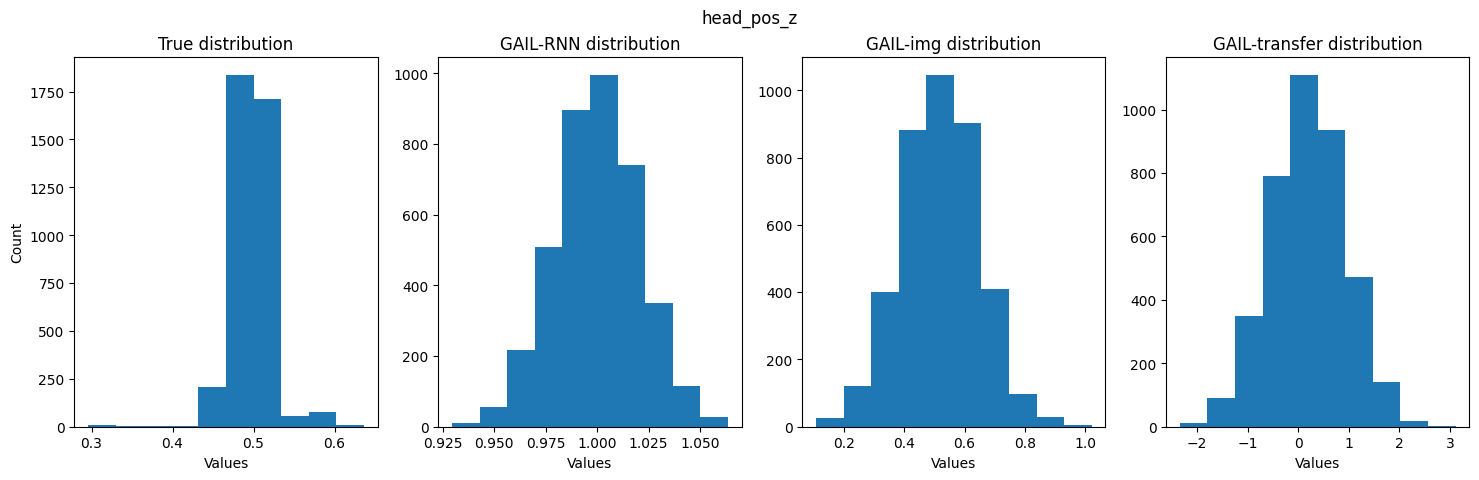

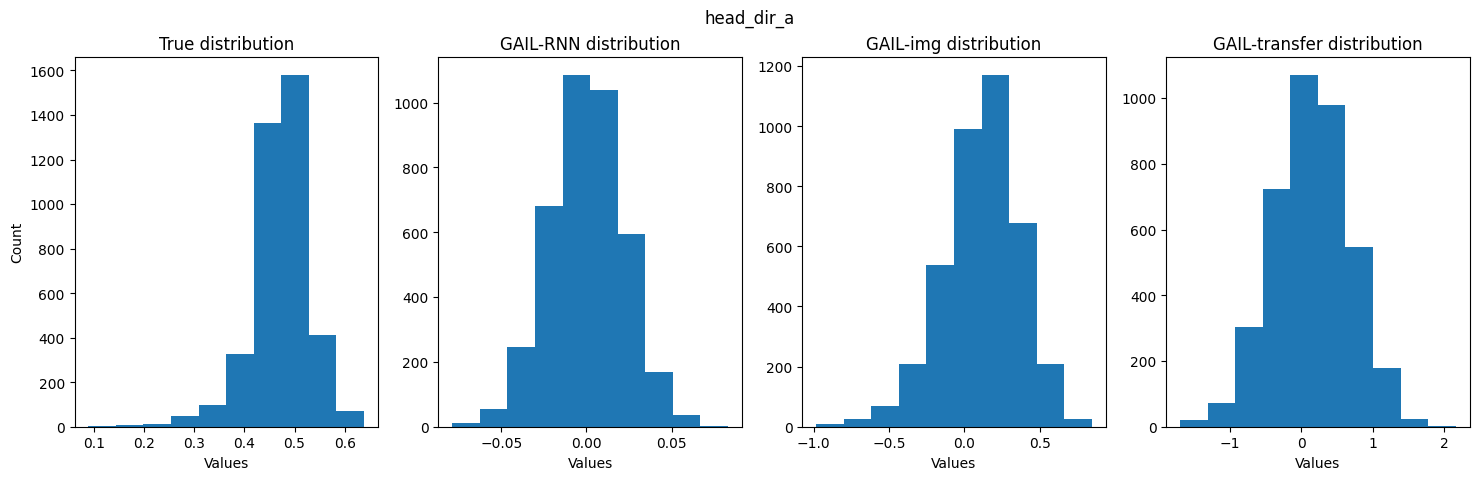

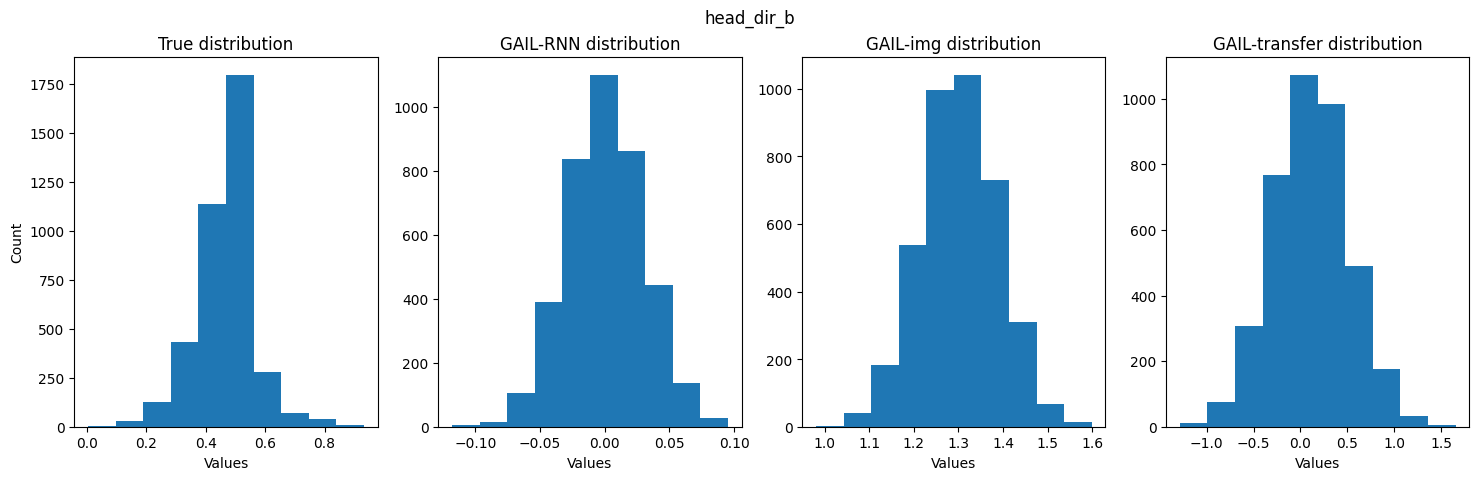

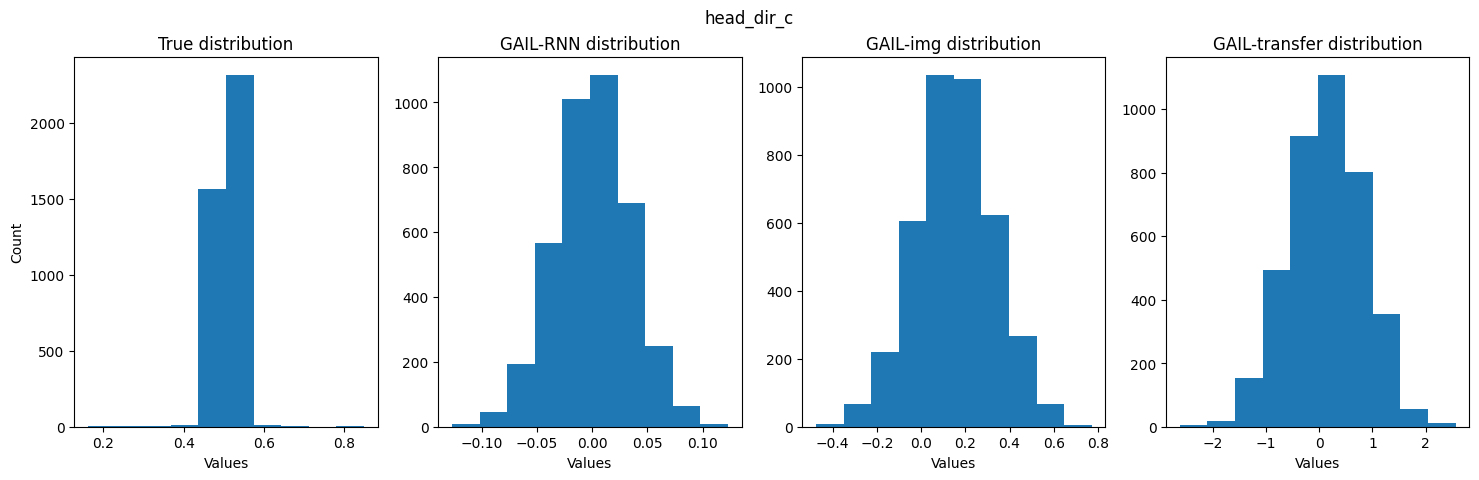

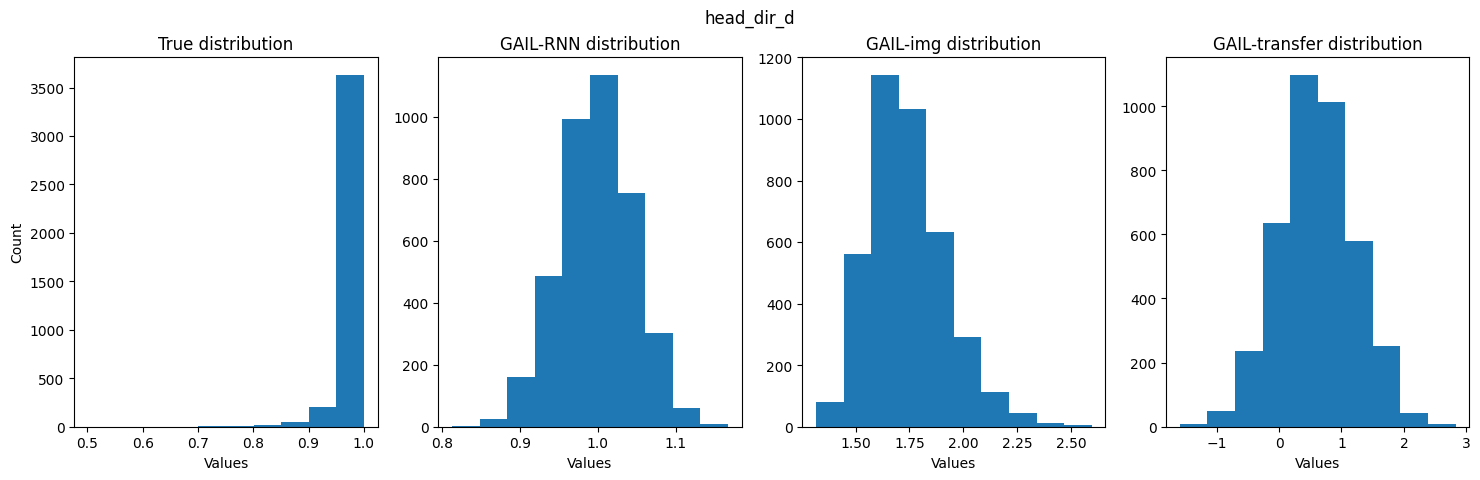

In [9]:
###################### Visualise distributions of each control ######################
import matplotlib.gridspec as gridspec

true_dist = fin_true_df.iloc[:, 2:]
pred_dist = fin_pred_df.iloc[:, 2:]
gail_dist = fin_gail_df.iloc[:, 2:]
vtra_dist = fin_vtra_df.iloc[:, 2:]
resn_dist = fin_resn_df.iloc[:, 2:]
resL_dist = fin_resL_df.iloc[:, 2:]
gimg_dist = fin_gimg_df.iloc[:, 2:]
gtra_dist = fin_gtra_df.iloc[:, 2:]

for i in range(11):
    fig, axs = plt.subplots(nrows=1, ncols=4)
    fig.set_figwidth(18)
    fig.suptitle(col_pred[i])

    axs[0].hist(true_dist.iloc[:, i])
    axs[0].set_title('True distribution')
    axs[0].set_ylabel('Count')
    axs[0].set_xlabel('Values')

    # axs[1].hist(pred_dist.iloc[:, i])
    # axs[1].set_title('CNN-RNN distribution')
    # axs[1].set_ylabel('Count')
    # axs[1].set_xlabel('Values')

    # axs[2].hist(vtra_dist.iloc[:, i])
    # axs[2].set_title('Vision Transformer distribution')
    # axs[2].set_ylabel('Count')
    # axs[2].set_xlabel('Values')

    # axs[3].hist(resn_dist.iloc[:, i])
    # axs[3].set_title('ResNet distribution')
    # axs[3].set_ylabel('Count')
    # axs[3].set_xlabel('Values')

    # axs[4].hist(resL_dist.iloc[:, i])
    # axs[4].set_title('ResNet-LSTM distribution')
    # axs[4].set_ylabel('Count')
    # axs[4].set_xlabel('Values')

    axs[1].hist(gail_dist.iloc[:, i])
    axs[1].set_title('GAIL-RNN distribution')
    # axs[1].set_ylabel('Count')
    axs[1].set_xlabel('Values')

    axs[2].hist(gimg_dist.iloc[:, i])
    axs[2].set_title('GAIL-img distribution')
    # axs[2].set_ylabel('Count')
    axs[2].set_xlabel('Values')

    axs[3].hist(gtra_dist.iloc[:, i])
    axs[3].set_title('GAIL-transfer distribution')
    # axs[3].set_ylabel('Count')
    axs[3].set_xlabel('Values')

plt.show()

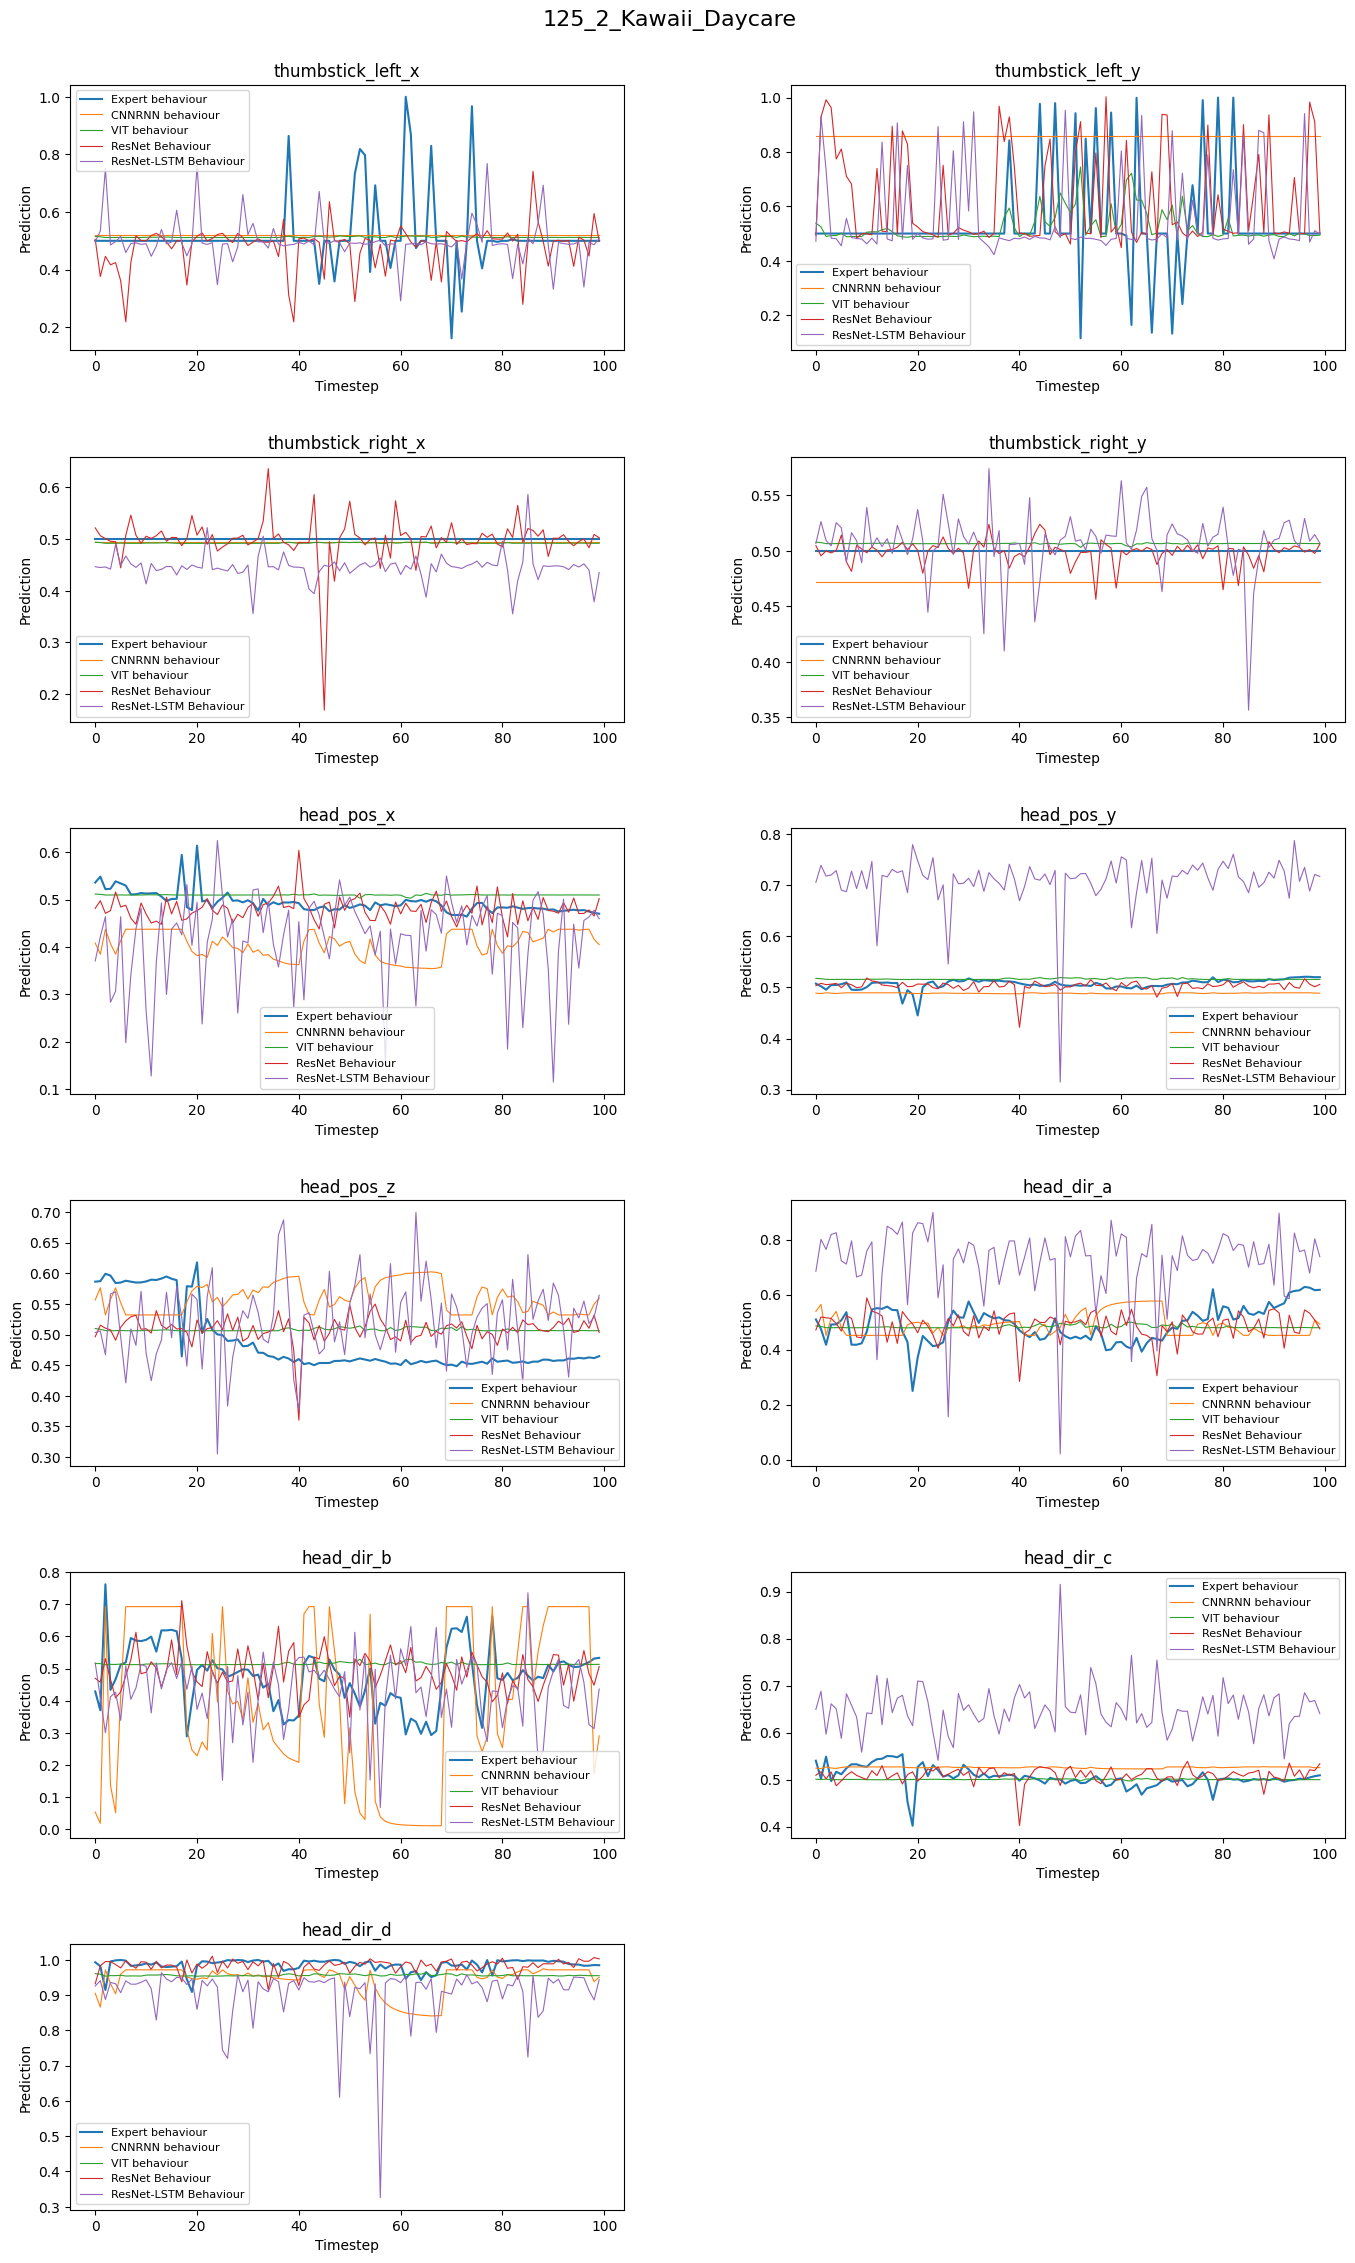

In [10]:
###################### Visualise behaviour given a sequence ######################
seq_inds = [0, 10, 25, 30]
seq_ind = seq_inds[0]
seq_length = 100

true_seq = fin_true_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
pred_seq = fin_pred_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
gail_seq = fin_gail_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
vtra_seq = fin_vtra_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
resn_seq = fin_resn_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
resL_seq = fin_resL_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
gimg_seq = fin_gimg_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
gtra_seq = fin_gtra_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]

title = fin_true_df.iloc[seq_length*seq_ind, 0:2]

fig, axs = plt.subplots(nrows=6, ncols=2)
fig.set_figheight(25)
fig.set_figwidth(15)
fig.delaxes(axs[5,1])
fig.suptitle(title.iloc[0], size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, ax in enumerate(axs.flat):
    if i == 11:
        break
    ax.plot(true_seq.iloc[:, i])
    ax.plot(pred_seq.iloc[:, i], linewidth='0.8')
    # ax.plot(gail_seq.iloc[:, i])
    ax.plot(vtra_seq.iloc[:, i], linewidth='0.8')
    ax.plot(resn_seq.iloc[:, i], linewidth='0.8')
    ax.plot(resL_seq.iloc[:, i], linewidth='0.8')
    ax.set_title(col_pred[i])
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Prediction')
    # ax.legend(['Expert behaviour', 'CNNRNN behaviour', 'GAIL behaviour', 'VIT behaviour', 'ResNet Behaviour'])
    ax.legend(['Expert behaviour', 'CNNRNN behaviour', 'VIT behaviour', 'ResNet Behaviour', 'ResNet-LSTM Behaviour'], fontsize=8)
    

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()

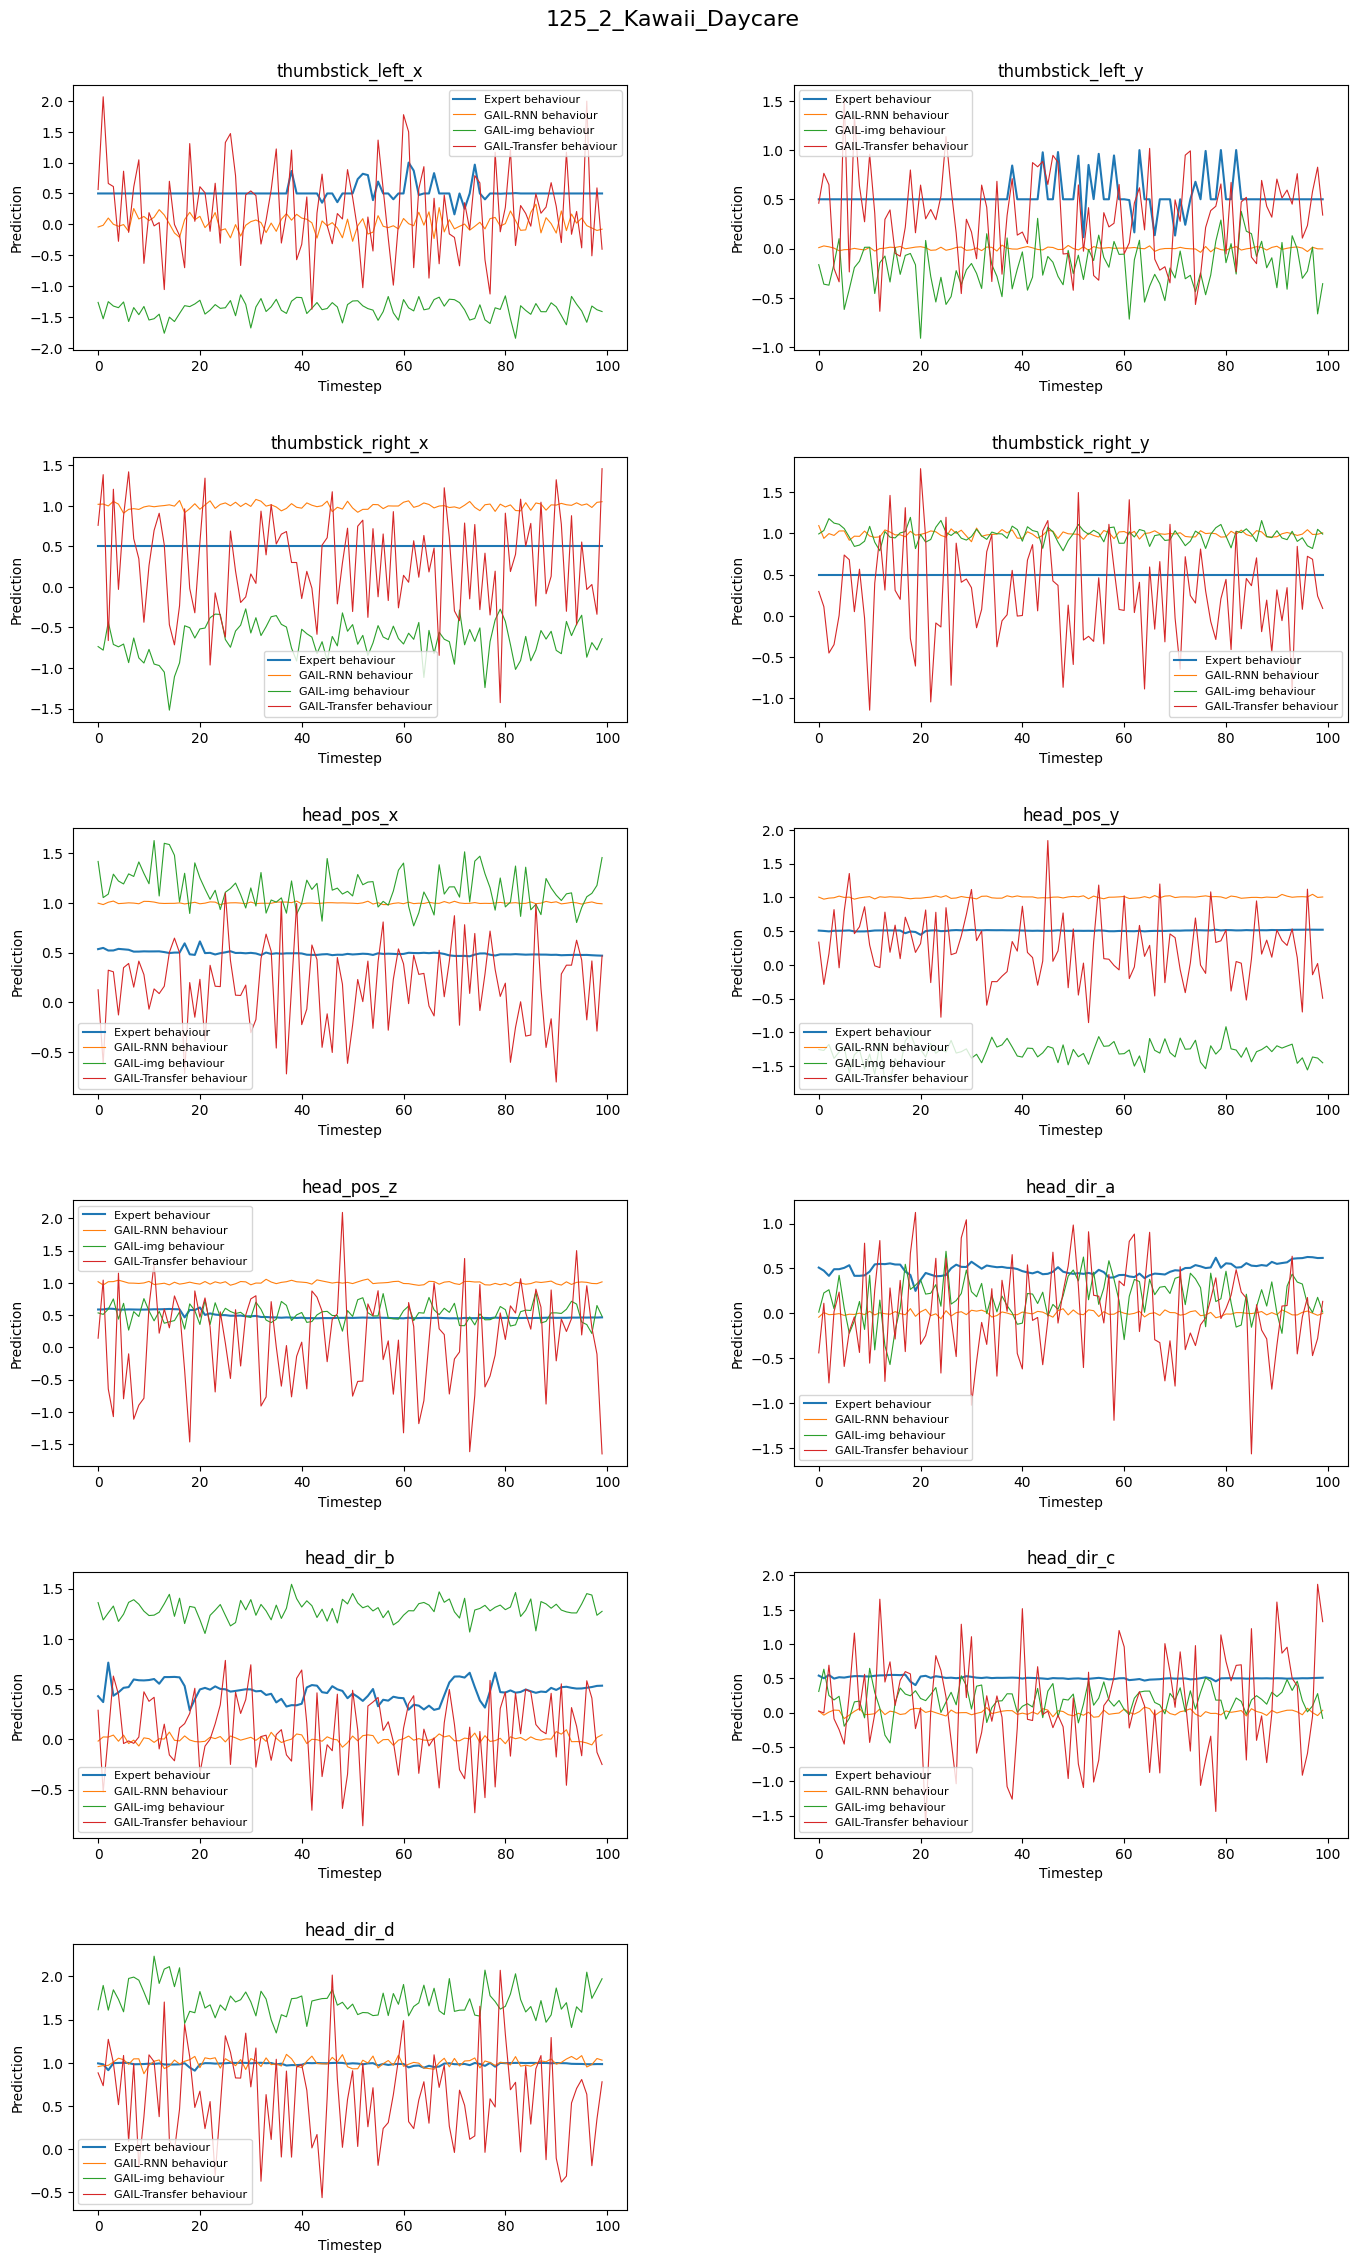

In [11]:
title = fin_true_df.iloc[seq_length*seq_ind, 0:2]

fig, axs = plt.subplots(nrows=6, ncols=2)
fig.set_figheight(25)
fig.set_figwidth(15)
fig.delaxes(axs[5,1])
fig.suptitle(title.iloc[0], size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, ax in enumerate(axs.flat):
    if i == 11:
        break
    ax.plot(true_seq.iloc[:, i])
    ax.plot(gail_seq.iloc[:, i], linewidth='0.8')
    ax.plot(gimg_seq.iloc[:, i], linewidth='0.8')
    ax.plot(gtra_seq.iloc[:, i], linewidth='0.8')
    ax.set_title(col_pred[i])
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Prediction')
    # ax.legend(['Expert behaviour', 'CNNRNN behaviour', 'GAIL behaviour', 'VIT behaviour', 'ResNet Behaviour'])
    ax.legend(['Expert behaviour', 'GAIL-RNN behaviour', 'GAIL-img behaviour', 'GAIL-Transfer behaviour'], fontsize=8)
    
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()

In [12]:
vtra_seq.head(50)

,thumbstick_left_x,thumbstick_left_y,thumbstick_right_x,thumbstick_right_y,head_pos_x,head_pos_y,head_pos_z,head_dir_a,head_dir_b,head_dir_c,head_dir_d,full_name
0,0.514968,0.538215,0.494037,0.507943,0.511698,0.517605,0.509834,0.486252,0.516036,0.500741,0.960831,125_2_Kawaii_Daycare110
1,0.513841,0.524601,0.493371,0.507495,0.510974,0.516894,0.508582,0.484054,0.515450,0.500236,0.959252,125_2_Kawaii_Daycare210
2,0.511614,0.489348,0.491918,0.506601,0.509688,0.515850,0.506503,0.479744,0.511787,0.501041,0.953781,125_2_Kawaii_Daycare310
3,0.511557,0.492565,0.491917,0.506550,0.509694,0.515477,0.506203,0.479556,0.513059,0.499815,0.955301,125_2_Kawaii_Daycare410
4,0.511635,0.492644,0.491962,0.506608,0.509754,0.515572,0.506328,0.479689,0.512919,0.500032,0.955169,125_2_Kawaii_Daycare510
5,0.511997,0.501543,0.492209,0.506695,0.509796,0.515699,0.506598,0.480492,0.514075,0.499583,0.956341,125_2_Kawaii_Daycare610
6,0.511488,0.488433,0.491867,0.506581,0.509658,0.515619,0.506290,0.479405,0.512172,0.500520,0.954172,125_2_Kawaii_Daycare710
7,0.511441,0.488637,0.491838,0.506543,0.509647,0.515528,0.506187,0.479311,0.512361,0.500279,0.954438,125_2_Kawaii_Daycare810
8,0.511480,0.489127,0.491864,0.506562,0.509649,0.515571,0.506240,0.479394,0.512370,0.500342,0.954409,125_2_Kawaii_Daycare910
9,0.511520,0.488913,0.491888,0.506589,0.509643,0.515664,0.506333,0.479484,0.512169,0.500591,0.954115,125_2_Kawaii_Daycare1010


In [13]:
test_disc = pd.read_csv("/data/mala711/COMPSCI715/GAIL/csv_files/test_disc_loss.csv")
train_disc = pd.read_csv("/data/mala711/COMPSCI715/GAIL/csv_files/train_dsc.csv")
train_ppo = pd.read_csv("/data/mala711/COMPSCI715/GAIL/csv_files/train_ppo.csv")

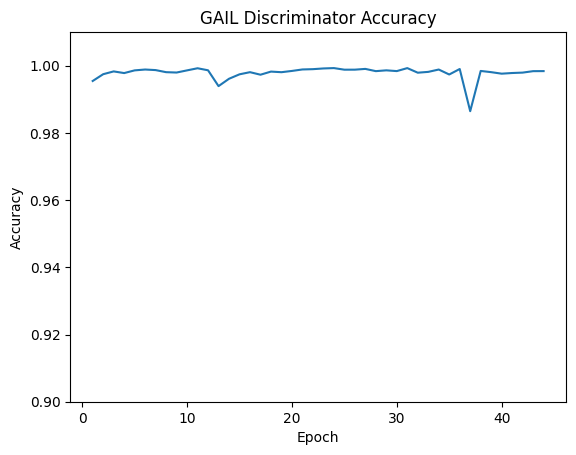

In [14]:
plt.plot(test_disc['Step'], 1-test_disc['Value'])
plt.ylim(0.90, 1.01)
plt.title('GAIL Discriminator Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

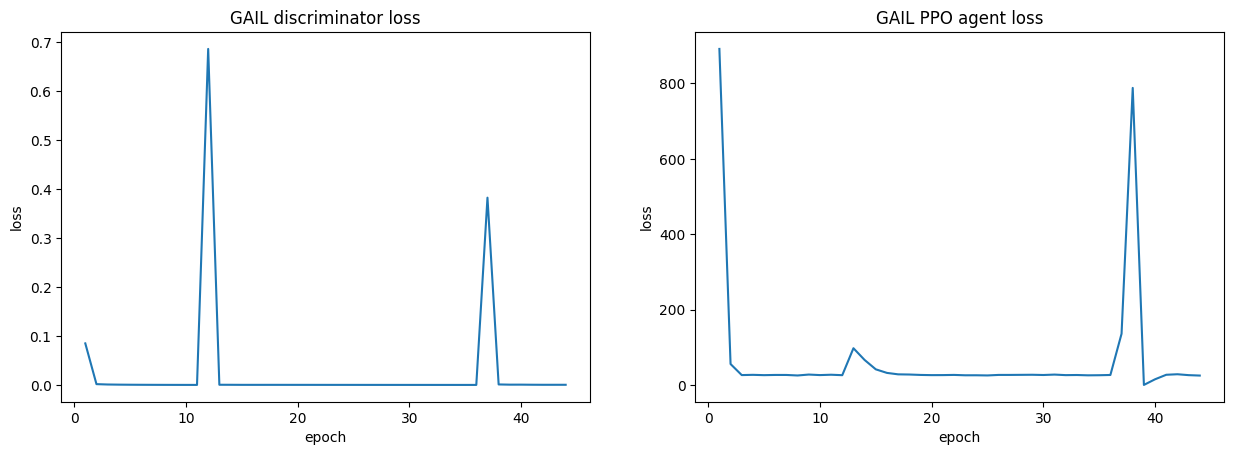

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(15)
axs[0].plot(train_disc['Step'], train_disc['Value'])
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].set_title('GAIL discriminator loss')
axs[1].plot(train_ppo['Step'], train_ppo['Value'])
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].set_title('GAIL PPO agent loss')
plt.show()

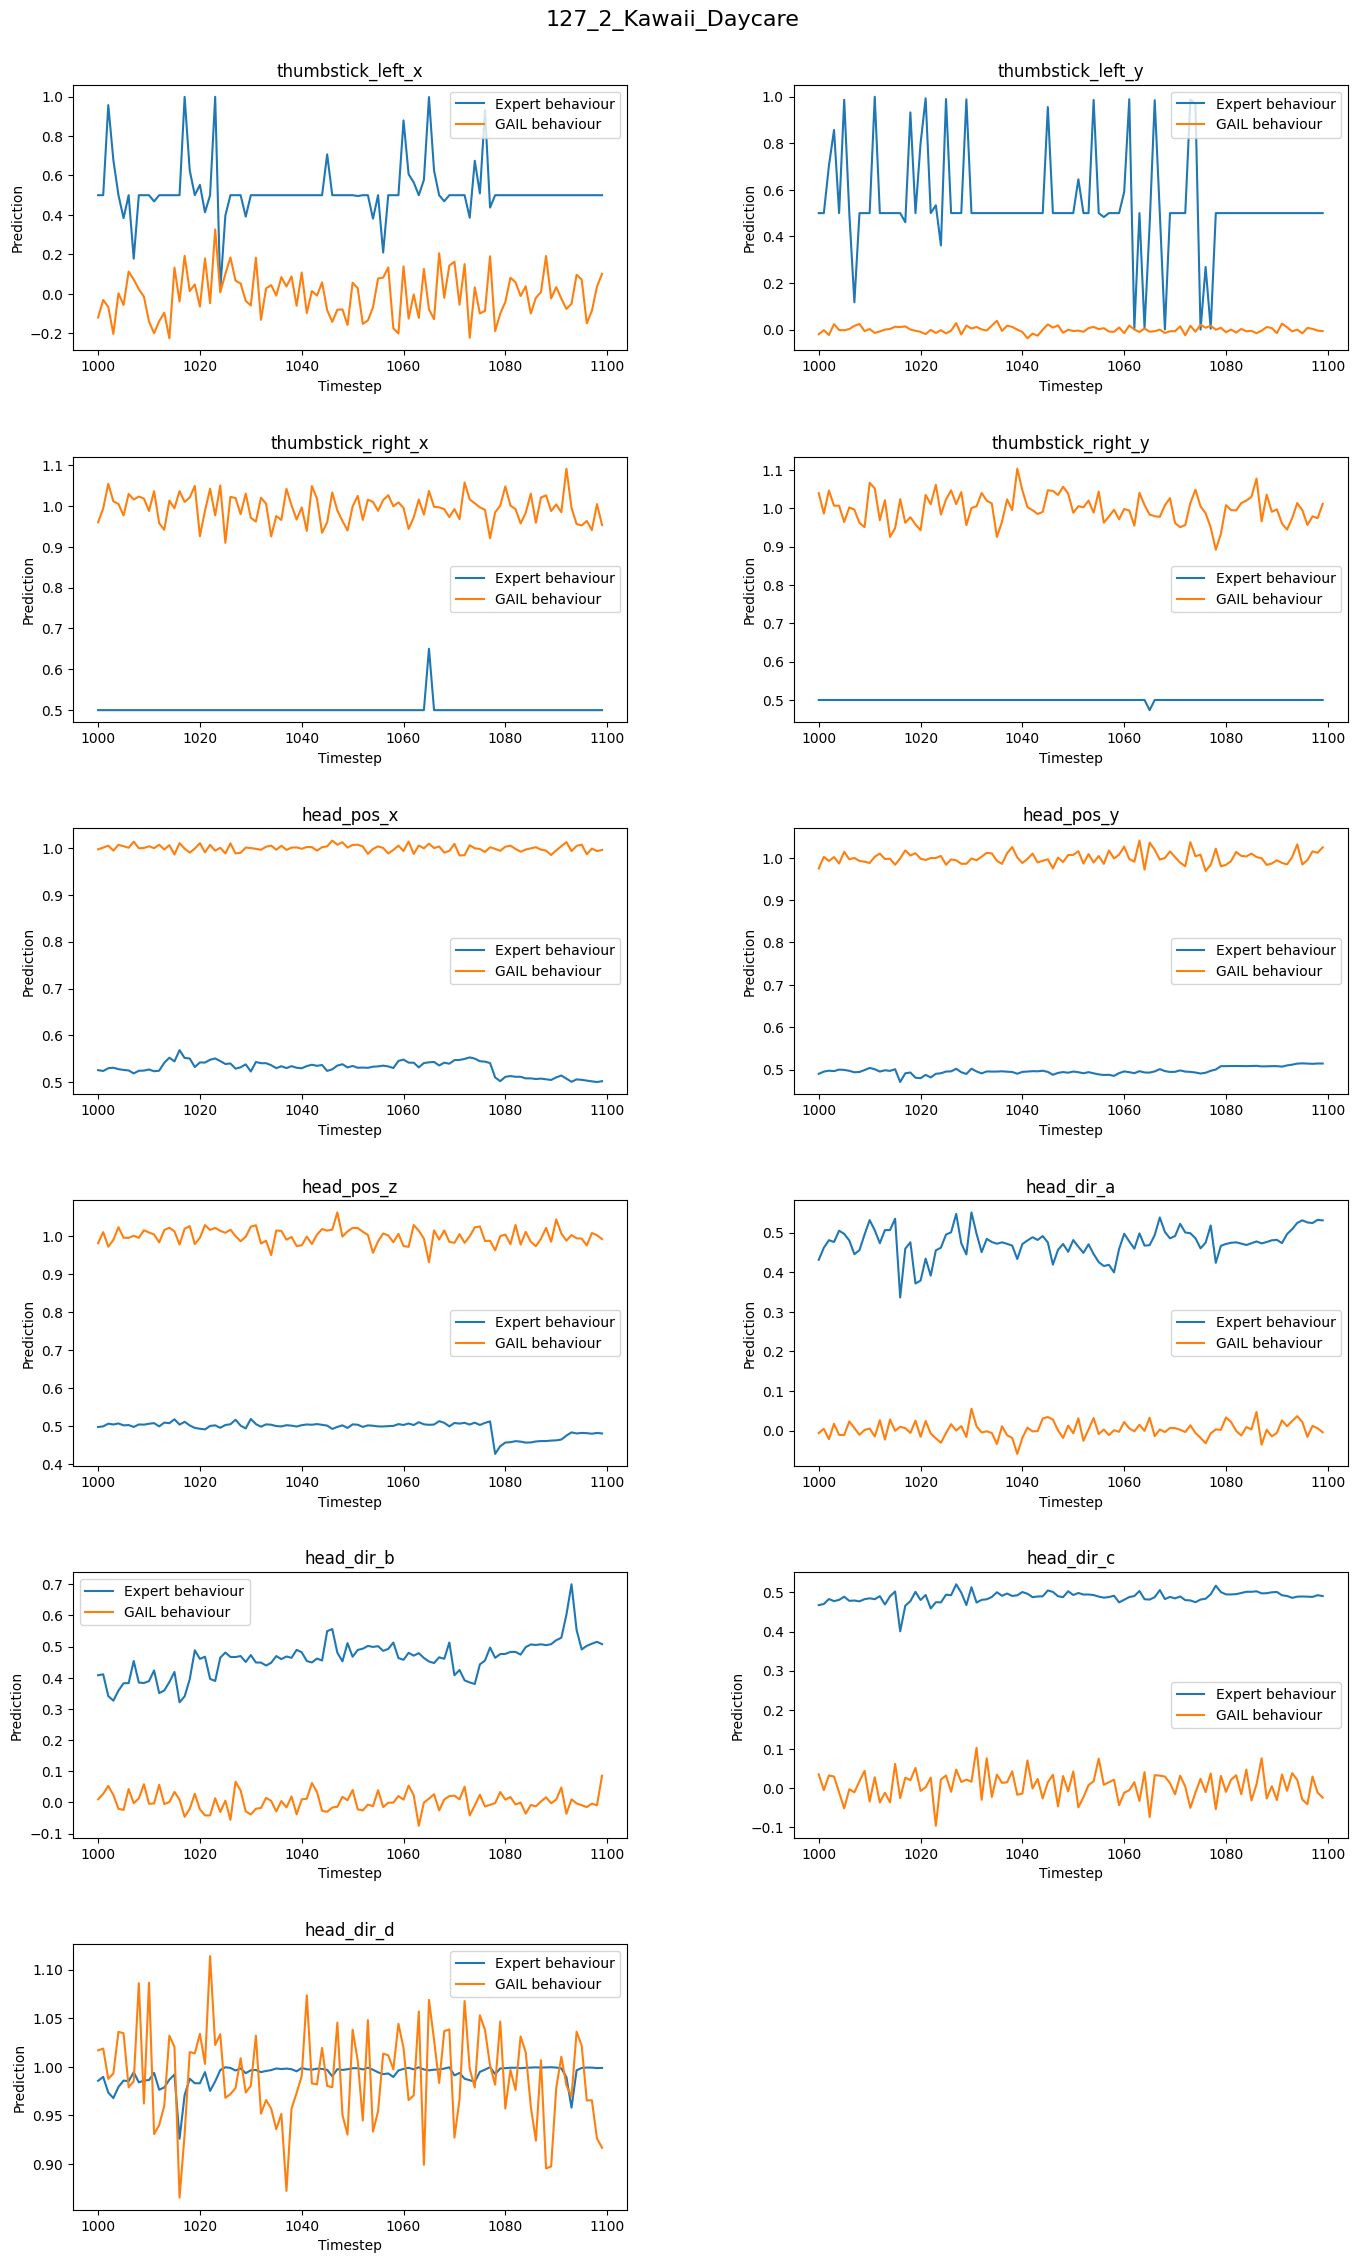

In [16]:
###################### Visualise behaviour given a sequence ######################
seq_ind = 10
seq_length = 100

true_seq = fin_true_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
pred_seq = fin_pred_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
gail_seq = fin_gail_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
vtra_seq = fin_vtra_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]
resn_seq = fin_resn_df.iloc[seq_length*seq_ind:seq_length*(seq_ind+1), 2:]


title = fin_true_df.iloc[seq_length*seq_ind, 0:2]

fig, axs = plt.subplots(nrows=6, ncols=2)
fig.set_figheight(25)
fig.set_figwidth(15)
fig.delaxes(axs[5,1])
fig.suptitle(title.iloc[0], size=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i, ax in enumerate(axs.flat):
    if i == 11:
        break
    ax.plot(true_seq.iloc[:, i])
    ax.plot(gail_seq.iloc[:, i])
    ax.set_title(col_pred[i])
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Prediction')
    # ax.legend(['Expert behaviour', 'CNNRNN behaviour', 'GAIL behaviour', 'VIT behaviour', 'ResNet Behaviour'])
    ax.legend(['Expert behaviour', 'GAIL behaviour'])

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()